## Spike sorting demo for BRW files
----

https://gist.github.com/mhhennig/97453faec66ea78f96e61a193f699e6c

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib
import sys, os

import spikeinterface.full as si
import spikeinterface.preprocessing as st

%matplotlib inline

Set the file path.

In [2]:
raw_file = pathlib.Path('Y:', 'users', 'michael.zabolocki', '3Brain_spikes_OC_Grade', 'OC_Ephis data', 'CTL', '021023_IN', 'Baseline', 's1_bs.brw')

# check the file path
if not raw_file.exists():
    print(f'File {raw_file} does not exist')
    sys.exit(1)

Initalized the object.

Files are stored as discrete 64-bit integers.

In [3]:
RX = si.BiocamRecordingExtractor(raw_file)
RX

BiocamRecordingExtractor: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                          150.00s (2.50 minutes) - uint16 dtype - 15.76 GiB
  file_path: Y:users\michael.zabolocki\3Brain_spikes_OC_Grade\OC_Ephis data\CTL\021023_IN\Baseline\s1_bs.brw

In [4]:
fs = RX.get_sampling_frequency()
chans = ['2825','2826','3415']  # select 'active' channels based on the json file
raw_voltages = RX.get_traces(start_frame=int(fs*0), end_frame=int(fs*60), channel_ids=chans)
raw_voltages

array([[2054, 2050, 2052],
       [2052, 2050, 2055],
       [2047, 2050, 2054],
       ...,
       [2042, 2049, 2043],
       [2045, 2054, 2043],
       [2048, 2051, 2046]], dtype=uint16)

Plot the raw traces for single indices.

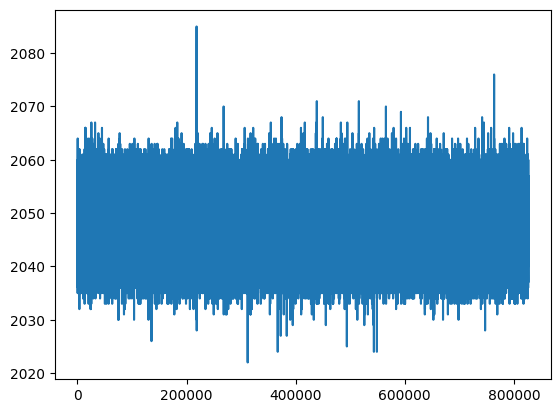

In [5]:
plt.plot(raw_voltages[:, 2])
plt.show()

Plot the raw traces.

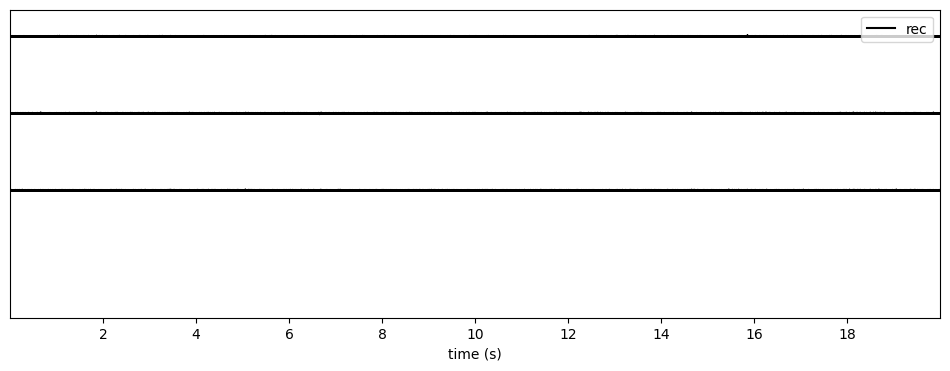

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(RX, time_range=[0,20], ax=ax, channel_ids=chans, color='k')

## Pre-processing
---

In [7]:
# RX_filtered = st.BlankSaturationRecording(RX, quantile_threshold=0.999)
# RX_filtered = st.normalize_by_quantile(RX_filtered, scale=20)

Bandpass filter.

In [8]:
RX_filtered_bpass = si.bandpass_filter(RX, freq_min=300, freq_max=3000)
RX_filtered_bpass

BandpassFilterRecording: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                         150.00s (2.50 minutes) - int16 dtype - 15.76 GiB

Remove bad channels.

In [9]:
# # detect
# bad_channel_ids, channel_labels = st.detect_bad_channels(recording=RX_filtered_bpass)
# # Case 1 : remove then
# rec_clean = RX_filtered_bpass.remove_channels(remove_channel_ids=bad_channel_ids)

# print(f'Bad channels: {bad_channel_ids}')

Common median reference.

In [10]:
recording_cmr = st.common_reference(recording=RX_filtered_bpass, operator="median")

Normalize the recordings. Apply the gains and offsets.

In [11]:
# rec_normed = st.zscore(recording=recording_cmr)

Bandpass filter and re-plot the data.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(recording_cmr, time_range=[0,20], ax=ax, channel_ids=chans)

## Spike-sorting
-----

First, check the available sorters.

In [46]:
import spikeinterface.sorters as ss

ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'simple',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

Pass the recording extractor.

In [48]:
# we pick a sorter...
Sorter = ss.sorter_dict['herdingspikes']

# create an object, passing the recording extractor
hs = Sorter(recording=recording_cmr, output_folder='hs_output', verbose=True)

Exception: The sorter herdingspikes is not installed. Please install it with:

To use HerdingSpikes run:

       >>> pip install herdingspikes
    More information on HerdingSpikes at:
      * https://github.com/mhhennig/hs2
    